In [1]:
import configparser

import torch
import model.net as net

import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from moviepy.editor import VideoFileClip

config = configparser.RawConfigParser()
config.read_file(open(r'./configuration.txt'))

In [2]:
device = torch.device('cpu')

input_channels = int(config.get('settings', 'input_channels'))
output_channels = int(config.get('settings', 'output_channels'))
model = net.Net(input_channels, output_channels).to(device)

checkpoint = torch.load('experiments/base_model/best.pth.tar', map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])
model.eval();

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


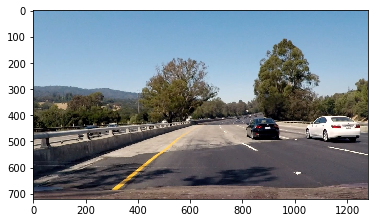

In [3]:
img = np.asarray(Image.open('test_images/test4.jpg'))
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)

In [4]:
def main_pipeline(img):
    imcopy = np.copy(img)
    
    imcopy = cv2.resize(imcopy, (160, 80))
    imcopy = imcopy[np.newaxis, ...]
    imcopy = np.transpose(imcopy, (0, 3, 1, 2))
    imcopy = torch.Tensor(imcopy)
    
    lane = model.forward(imcopy)
    lane = torch.sigmoid(lane)
    lane = lane.detach().numpy()[0, 1] * 255
    
    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(lane).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lane, blanks))
    
    lane_drawn = cv2.resize(lane_drawn, (1280, 720)).astype(np.uint8)
    result = cv2.addWeighted(lane_drawn, 1, img, 1, 0)

    return result

# Test on one image

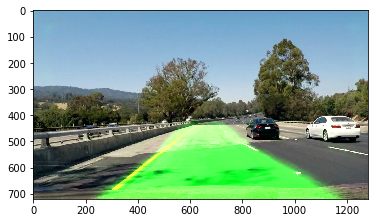

In [5]:
result = main_pipeline(img)
plt.imshow(result)

# Test on video

In [6]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 3/1260 [00:00<01:03, 19.81it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 4min 55s, sys: 41.7 s, total: 5min 36s
Wall time: 1min 22s
